In [ ]:
%%capture
import sys
#importing data to google colab

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://www.kaggle.com/drgilermo/nba-players-stats?select=Players.csv'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split, RandomizedSearchCV

# encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

#metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, mean_absolute_error, r2_score, mean_squared_error

#pipeline
from sklearn.pipeline import make_pipeline

# machine learning
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Boosted Models
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xg

# Permutation Importance
from sklearn.inspection import permutation_importance 

# for displaying images and html
from IPython.display import Image
from IPython.core.display import HTML 

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# mounting your google drive on colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#change your working directory, if you want to or have already saved your kaggle dataset on google drive.
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
# List all files in your Kaggle folder on your google drive.
!ls

2021-12-08_2259_submission_12_8.csv  player_data.csv	    submissionsss.csv
2021-12-08_2300_submission.csv	     Players.csv	    test_features.csv
2021-12-08_2301_submission.csv	     sample_submission.csv  train_features.csv
ds34-water-pump-challenge.zip	     Seasons_Stats.csv	    train_labels.csv
kaggle.json			     submission_12_6.csv
NBA_Project.csv			     submission_12_7.csv


# I. Wrangle Data

In [ ]:
#wrangle data
def wrangle(filepath):
  
  #merge players.csv and seasons_stats.csv
  df = pd.merge(pd.read_csv('Players.csv'),pd.read_csv('Seasons_Stats.csv'), how='outer', on='Player').set_index('Year')
  #Using only data after 1980 as it has all data points
  df = df.query('Year > 1980')
  #drop columns that either have no data or make the model skewed
  df.drop(columns=['blanl','blank2','Unnamed: 0_x','Unnamed: 0_y','height','weight','collage','born','birth_city','birth_state','Tm','Pos','OBPM','DBPM','3PAr','Age','USG%','ORB','WS/48','OWS'], inplace=True)

  return df

filepath = DATA_PATH + 'Players.csv' + 'Seasons_Stats.csv'

In [ ]:
#print dataframe head
df = wrangle(filepath)
df

,Player,G,GS,MP,PER,TS%,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,DWS,WS,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1981.0,Jim Paxson,79.0,NaN,2701.0,16.9,0.564,0.227,3.0,5.5,4.3,15.3,2.4,0.2,9.8,2.1,7.7,1.4,2.3,585.0,1092.0,0.536,2.0,30.0,0.067,583.0,1062.0,0.549,0.537,182.0,248.0,0.734,137.0,211.0,299.0,140.0,9.0,131.0,172.0,1354.0
1982.0,Jim Paxson,82.0,82.0,2756.0,18.0,0.561,0.228,3.1,5.9,4.5,14.8,2.2,0.2,9.4,1.8,7.5,0.9,2.1,662.0,1258.0,0.526,8.0,35.0,0.229,654.0,1223.0,0.535,0.529,220.0,287.0,0.767,146.0,221.0,276.0,129.0,12.0,144.0,159.0,1552.0
1983.0,Jim Paxson,81.0,81.0,2740.0,20.1,0.573,0.361,2.8,4.4,3.6,13.5,2.4,0.3,9.2,2.4,10.2,1.8,2.6,682.0,1323.0,0.515,4.0,25.0,0.160,678.0,1298.0,0.522,0.517,388.0,478.0,0.812,106.0,174.0,231.0,140.0,17.0,156.0,160.0,1756.0
1984.0,Jim Paxson,81.0,81.0,2686.0,19.5,0.573,0.310,2.9,4.8,3.8,14.1,2.2,0.2,8.6,1.9,9.5,1.1,2.1,680.0,1322.0,0.514,17.0,59.0,0.288,663.0,1263.0,0.525,0.521,345.0,410.0,0.841,105.0,173.0,251.0,122.0,10.0,142.0,165.0,1722.0
1985.0,Jim Paxson,68.0,57.0,2253.0,17.3,0.555,0.251,3.4,7.6,5.5,16.6,2.1,0.1,9.0,1.9,6.5,1.0,1.7,508.0,988.0,0.514,6.0,39.0,0.154,502.0,949.0,0.529,0.517,196.0,248.0,0.790,153.0,222.0,264.0,101.0,5.0,108.0,115.0,1218.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017.0,Troy Williams,6.0,3.0,139.0,12.8,0.616,0.159,7.1,11.8,9.4,6.4,1.0,0.6,11.3,0.1,0.3,-1.7,0.0,22.0,44.0,0.500,8.0,21.0,0.381,14.0,23.0,0.609,0.591,6.0,7.0,0.857,15.0,24.0,6.0,3.0,1.0,6.0,18.0,58.0
2017.0,Kyle Wiltjer,14.0,0.0,44.0,6.7,0.437,0.143,9.9,14.9,12.4,6.1,3.3,1.8,25.2,0.1,0.0,-4.0,0.0,4.0,14.0,0.286,4.0,13.0,0.308,0.0,1.0,0.000,0.429,1.0,2.0,0.500,6.0,10.0,2.0,3.0,1.0,5.0,4.0,13.0
2017.0,Stephen Zimmerman,19.0,0.0,108.0,7.3,0.346,0.161,10.8,24.9,17.6,5.3,0.9,3.7,8.3,0.1,0.0,-7.3,-0.1,10.0,31.0,0.323,0.0,0.0,NaN,10.0,31.0,0.323,0.323,3.0,5.0,0.600,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0


In [ ]:
#fill na values with mean of the column
df.fillna(value=df.mean(), inplace=True)

# II. Split Data

In [ ]:
#set target and variables
#I choose PER because I think that is the best thing to grade a NBA player on when it comes to efficency
target = 'PER'
y = df[target]
X = df.drop(target, axis=1)

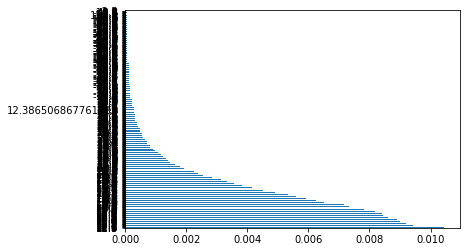

In [ ]:
#feature averages for NBA Players
y.value_counts(normalize=True).plot(kind='barh')

In [ ]:
# I choose 2010 as the index year to train and validate my data as a lot of rules in the NBA have changed and by 2010 the game is a lot more similar to what it is today and it is about 80% of the data to train
mask = X.index < 2010
X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

# III. Establish Baseline

In [ ]:
#Baseline accuracy
print('Baseline accuracy:',  y_train.value_counts(normalize=True).max())

Baseline accuracy: 0.011321352228643812


In [ ]:
#Mean PER and Baseline MAE
print('Mean PER:', y_train.mean())

y_pred = [y_train.mean()] * len(y_train)
print('Baseline MAE:', mean_absolute_error(y_train,y_pred))

Mean PER: 12.337089146839974
Baseline MAE: 4.0880136027553595


In [ ]:
#Baseline MSE
print('Baseline MSE:', mean_squared_error(y_train, y_pred))

Baseline MSE: 38.24033328338844


# IV. Build Model

In [ ]:
#Model 1: Linear Regression
model_lr = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    LinearRegression()
)

model_lr.fit(X_train, y_train);

In [ ]:
#Model 2: Ridge Regression
model_r = make_pipeline(
    OneHotEncoder(use_cat_names=True), # Encode categorical values
    SimpleImputer(strategy='mean'), # fills Nan values with column mean
    StandardScaler(), # re-scales all features  (mean = 0, std=1)
    Ridge(alpha=1)
)

model_r.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Player'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=1))])

In [ ]:
#Model 3: Random forest regressor 
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor(random_state=42) # n_estimators default it 100 so changing 25 for time effectiveness.
)
model_rf.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Player'],
                                mapping=[{'col': 'Player',
                                          'data_type': dtype('O'),
                                          'mapping': Jim Paxson             1
Hot Rod                2
Luke Jackson           3
Elvin Hayes*           4
Wes Unseld*            5
                    ... 
Justin Williams     2051
Marcus Williams     2052
Shawne Williams     2053
Shelden Williams    2054
NaN                   -2
Length: 2055, dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

# IV. Check Metrics

In [ ]:
#Accuracy, Mean Absolute Error, and Mean Squared Error for all 3 models
def check_metrics(model):
  # print(model)
  print('Training Accuracy:', model.score(X_train,y_train))
  print('Validation Accuracy:', model.score(X_val,y_val))
  print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))
  print('Training MSE:', mean_squared_error(y_train, model.predict(X_train)))
  print('Validation MSE:', mean_squared_error(y_val, model.predict(X_val)))
  print()
  print()

models = [model_lr, model_r, model_rf]

for m in models:
  check_metrics(m)

Training Accuracy: 0.896132768147044
Validation Accuracy: 0.8897999204091251
Training MAE: 1.0090682214221272
Validation MAE: 1.0520478727441054
Training MSE: 4.048887235709577
Validation MSE: 4.181401342804455


Training Accuracy: 0.940578962951977
Validation Accuracy: 0.8723476674908079
Training MAE: 0.7987372345554672
Validation MAE: 1.1758875526300931
Training MSE: 2.3163135682384075
Validation MSE: 4.843604800901208


Training Accuracy: 0.9724023245159263
Validation Accuracy: 0.8536529682072833
Training MAE: 0.5164748965770887
Validation MAE: 1.4423652623850298
Training MSE: 1.0757952629459704
Validation MSE: 5.552951300265515




# V. Communicate Results

In [ ]:
#permutation importance to find most crucial features

perm_imp = permutation_importance(model_rf, X_val, y_val, random_state=42)

In [ ]:
#Setting features to importance values in relation to PER
data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}

df_perm = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')

In [ ]:
df_perm

,imp_mean,imp_std
Player,-0.000256,0.000495
3PA,-0.000141,0.000072
3P,0.000008,0.000042
3P%,0.000050,0.000055
FT%,0.000176,0.000286
GS,0.000185,0.000120
TRB,0.000225,0.000122
STL,0.000359,0.000121
DWS,0.000359,0.000161
DRB,0.000383,0.000064


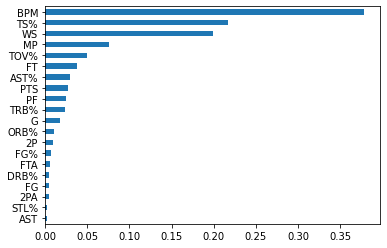

In [ ]:
#top 20 feature importances to PER for NBA Players from 1980 to 2017
df_perm['imp_mean'].tail(20).plot(kind='barh')

In [ ]:
#https://mis304bradleybaker.wordpress.com/2021/12/22/nba-statistics-impact-on-player-efficiency-rating/